In [1]:
import pandas as pd
import numpy as np 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import seaborn as sns
from scipy.stats import t
import scipy as sc

# Questão 1

Lendo a tabela:

In [2]:
df = pd.read_csv('prod_table.csv', sep = ',')
df_treated = pd.DataFrame(df.iloc[:,0:3])
to_app = df.iloc[:,3:6]
to_app.columns = ['Produção', 'Temperatura', 'Concentração']
df_treated = pd.concat([df_treated, to_app], ignore_index = True)
df_treated.head()

,Produção,Temperatura,Concentração
0,189,80,10
1,203,100,10
2,222,120,10
3,234,140,10
4,261,160,10


a) Ajustando um modelo de regressão para a produção (Y) em função da temperatura ($x_1$) e concentração ($x_2$).

In [3]:
results = smf.ols('Produção ~ Temperatura + Concentração', data=df_treated).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Produção   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     215.9
Date:                Tue, 08 Nov 2022   Prob (F-statistic):           8.23e-13
Time:                        09:06:12   Log-Likelihood:                -62.739
No. Observations:                  20   AIC:                             131.5
Df Residuals:                      17   BIC:                             134.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       93.1800      7.254     12.845      0.000      77.875     108.485
Temperatura      0.8700      0.048     18.204      0.000       0.769       0.971
Concentração     2.4240      0.242     10.025      0.000       1.914       2.934
==============================================================================
Omnibus:                        0.340   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.844   Jarque-Bera (JB):                0.497
Skew:                          -0.170   Prob(JB):                        0.780
Kurtosis:                       2.307   Cond. No.                         668.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

O modelo obtido é definido como:
    
$$
Y_{i} = 93.1800 + 0.87x_1 + 2.424x_2
$$

Como os coeficientes são positivos, eles demonstram que a temperatura e a concentração são positivamente correlacionados com a produção. Além disso, o valor desses coeficientes nos dão a taxa com que a produção aumenta de acordo com a covariável. Por exemplo: ao aumentar em 1 grau a temperatura, a produção aumenta em 0.87.

b) Verificando suposições do modelo.

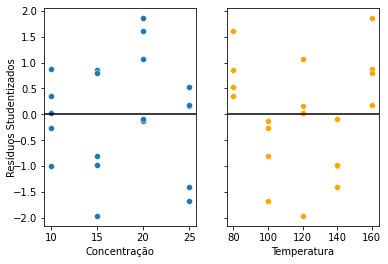

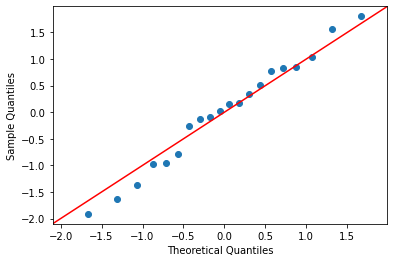

In [4]:
def student_residuals(results, df_treated):
    x = df_treated[['Temperatura', 'Concentração']].to_numpy()
    errors = df_treated['Produção'].to_numpy() - results.predict()
    hat = np.dot(np.dot(x,np.linalg.inv(np.dot(x.T, x))),x.T)
    hat_diag = hat.diagonal()
    student = []
    for i in range(0,len(hat_diag)):
        e = errors[i]/np.sqrt(errors.var(ddof = 1)*(1-hat_diag[i]))
        student.append(e)
    
    
    fig, axs = plt.subplots(ncols=2, sharey = True)
    fig.text(0.04, 0.5, 'Resíduos Studentizados', va='center', rotation='vertical')
    a = sns.scatterplot(x = df_treated['Concentração'], y = student, ax = axs[0])
    b = sns.scatterplot(x = df_treated['Temperatura'], y = student, ax = axs[1], color = 'orange')
    a.axhline(0, color = 'black')
    b.axhline(0, color = 'black')
    
    qqplot = sm.qqplot(np.array(student), fit=True, line="45")


    

student_residuals(results, df_treated)


Como os resíduos parecem estar uniformemente distribuídos ao redor do 0 (linha horizontal) para ambas as covariáveis e a sua variação parece constante, o modelo adquirido parece satisfazer as suposições de que os erros possuem variância constante e média zero.

Realizando o teste Shapiro-Wil para normalidade e Breusch-Pagan para homegeneidade de variância, nossas hipóteses são confirmadas.

In [5]:
print(f'Shapiro-Wilk p-valor: {sc.stats.shapiro(results.resid)[1]}')
print(f'Breusch-Pagan p-valor : {sms.het_breuschpagan(results.resid, results.model.exog)[1]}')


Shapiro-Wilk p-valor: 0.9198963046073914
Breusch-Pagan p-valor : 0.6991257173465322


Ao analisar o QQPlot não notamos graves desvios em relação a reta afim, o que demonstra que os quantis dos resíduos se aproximam dos quantis da distribuição normal.

c) Relações

Verificando a seguinte hipótese:
    
$$
H_0: \beta_1 = \beta_2 = 0 \quad \textrm{vs} \quad H_1: \beta_j \neq 0 \quad \textrm{para pelo menos um j, j= 1,2}
$$

In [6]:
print(f'O p-valor é {results.f_pvalue}')

O p-valor é 8.234401303556645e-13


Logo, ao nível de significância 5% e de acordo com os dados utilizados, rejeitamos a hipótese de que ambos os coeficientes da regressão são nulos e, então, ao menos um deles explica a variabilidade da produção.

d) Porcentagem da variabilidade explicada pelas covariáveis

In [7]:
print(f'O coeficiente de determinação R-Squared foi de {round(results.rsquared,2)}')

O coeficiente de determinação R-Squared foi de 0.96


e) Contribuição individual das covariáveis

Verificando a seguinte hipótese:
    
$$
H_0: \beta_1  = 0 \quad \textrm{vs} \quad H_1: \beta_1 \neq 0 
$$

In [8]:
print(f'O p-valor obtido foi de : {results.f_test("Temperatura = 0").pvalue}')

O p-valor obtido foi de : 1.3842607977678764e-12


$$
H_0: \beta_2  = 0 \quad \textrm{vs} \quad H_1: \beta_2 \neq 0 
$$

In [9]:
print(f'O p-valor obtido foi de : {results.f_test("Concentração = 0").pvalue}')

O p-valor obtido foi de : 1.493479291510911e-08


Logo, ao nível de significância de 5%, rejeitamos ambas as hipóteses nulas, ou seja, ambos os coeficientes contribuem significativamente para o modelo de regressão.

f) Qual variável é mais importante?

In [10]:
res_wb1 = smf.ols('Produção ~ Concentração', data=df_treated).fit()
res_wb2 = smf.ols('Produção ~ Temperatura', data=df_treated).fit()

sqreg = np.sum((results.predict() - df_treated['Produção'].mean())**2)
total_sqt = sqreg + results.ssr
sqregb1 = np.sum((res_wb1.predict() - df_treated['Produção'].mean())**2)
sqregb2 = np.sum((res_wb2.predict() - df_treated['Produção'].mean())**2)


sqreg_b1 = sqreg - sqregb1
sqreg_b2 = sqreg - sqregb2


print(f'R2B1: {sqreg_b1/total_sqt} \n R2B2: {sqreg_b2/total_sqt}')

R2B1: 0.7382589612289695 
 R2B2: 0.22386978785662096


g) Intervalo de confiança

In [11]:


def ic(xo, results, alpha = 0.5):
    mean = results.predict({'Temperatura': xo[0], 'Concentração' : xo[1]})[0]
    p = results.df_model + 1
    n = results.df_model + results.df_resid +1
    x = df_treated[['Temperatura', 'Concentração']].to_numpy()
    xo = np.array([125,14])
    aux = np.dot(np.dot(xo.T,np.linalg.inv(np.dot(x.T, x))), xo)
    sigma_xapeu = results.ssr/(n-p)
    sup = mean - t.ppf(alpha/2, n-p)*np.sqrt(sigma_xapeu*aux)
    inf = mean + t.ppf(alpha/2, n-p)*np.sqrt(sigma_xapeu*aux)
    
    inf = round(inf,2)
    sup = round(sup,2)
    return mean, inf, sup
xo = np.array([125,14])
mean, inf, sup = ic(xo, results)

print(f'A resposta média para a temperatura de 125° e 14% foi de {round(mean,2)} \n IC(95%): [{inf},{sup}]')

A resposta média para a temperatura de 125° e 14% foi de 235.87 
 IC(95%): [234.82,236.91]


Ao nível de confiança de 5% não podemos afirmar que a quantidade média de produtos é no mínimo 240, pois esse valor não está nos limites do intervalo de confiança.

h) Intervalo de confiança de 99%

In [12]:
mean, inf, sup = ic(xo, results, alpha = 0.01)
print(f'A resposta média para a temperatura de 125° e 14% foi de {round(mean,2)} \n IC(99%): [{inf},{sup}]')

A resposta média para a temperatura de 125° e 14% foi de 235.87 
 IC(99%): [231.48,240.25]


# Questão 2

In [17]:
df = pd.read_csv('exp_table.csv', sep = ',')
df.columns

Index(['Experimento', 'Y1', 'Y2', 'Y3', 'X1', 'X2', 'X3'], dtype='object')

In [26]:
from sklearn import linear_model
y = df[['Y1','Y2','Y3']]
x = df[['X1','X2','X3']]
clf = linear_model.LinearRegression().fit(x,y)
clf.coef_, clf.intercept_


(array([[-1.54596082, -1.42455873, -2.23736565],
        [ 0.40455059,  0.29298999,  1.03380047],
        [ 0.91392477,  0.89947254,  1.15348549]]),
 array([ 332.11098334,  -26.03526431, -164.0789411 ]))

In [44]:
m1 = smf.ols('Y1 ~ X1 + X2 + X3', data=df).fit()
m2 = smf.ols('Y2 ~ X1 + X2 + X3', data=df).fit()
m3 = smf.ols('Y3 ~ X1 + X2 + X3', data=df).fit()
print(f'Y1 \n{m1.params} \nY2 \n{m2.params} \nY3 \n{m3.params}')

Y1 
Intercept    332.110983
X1            -1.545961
X2            -1.424559
X3            -2.237366
dtype: float64 
Y2 
Intercept   -26.035264
X1            0.404551
X2            0.292990
X3            1.033800
dtype: float64 
Y3 
Intercept   -164.078941
X1             0.913925
X2             0.899473
X3             1.153485
dtype: float64


Assim, os modelos gerados são dados por:

$$
Y_1 = 332.110 -1.545 X_1 - 1.424X_2 - 2.237 X_3 \\
Y_2 = -26.035 + 0.404 X_1 + 0.292 X_2 + 1.033 X_3 \\
Y_3 = -164.078 + 0.913 X_1 + 0.899 X_2 + 1.153 X_3 \\
$$


em que cada coeficiente representa o impacto da mudança de uma unidade da covariável a qual ele está associado, a variável resposta.

b) Suposições do modelo

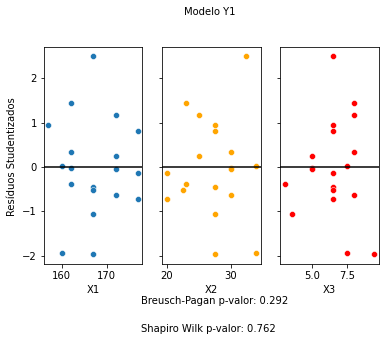

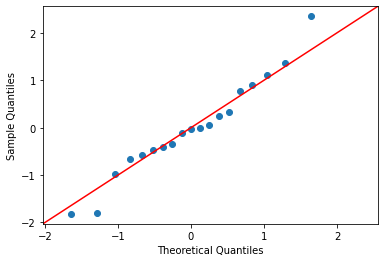

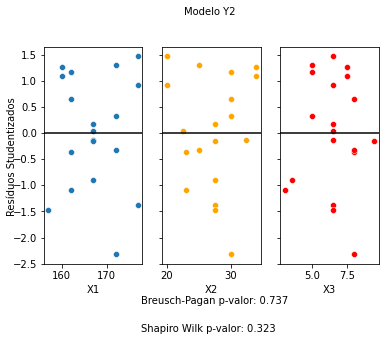

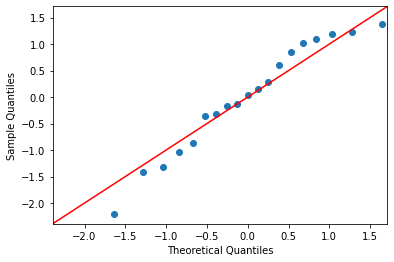

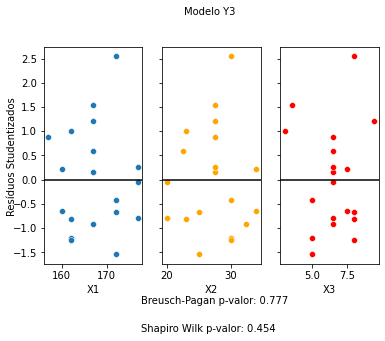

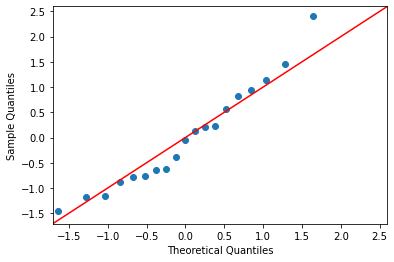

In [102]:
def student_residuals(results, df_treated, dependent):
    x = df_treated[['X1', 'X2','X3']].to_numpy()

    
    errors = df_treated[dependent].to_numpy() - results.predict()
    hat = np.dot(np.dot(x,np.linalg.inv(np.dot(x.T, x))),x.T)
    hat_diag = hat.diagonal()
    student = []
    s1 = round(sc.stats.shapiro(results.resid)[1],3)
    bp = round(sms.het_breuschpagan(results.resid, results.model.exog)[1],3)
    for i in range(0,len(hat_diag)):
        e = errors[i]/np.sqrt(errors.var(ddof = 1)*(1-hat_diag[i]))
        student.append(e)
    
    fig, axs = plt.subplots(ncols=3, sharey = True)
    fig.text(0.45, 1, f'Modelo {dependent}', va='center', rotation='horizontal')
    fig.text(0.04, 0.5, 'Resíduos Studentizados', va='center', rotation='vertical')
    a = sns.scatterplot(x = df_treated['X1'], y = student, ax = axs[0])
    b = sns.scatterplot(x = df_treated['X2'], y = student, ax = axs[1], color = 'orange')
    c = sns.scatterplot(x = df_treated['X3'], y = student, ax = axs[2], color = 'red')
    fig.text(0.35, -0.003, f'Breusch-Pagan p-valor: {bp}', va='center', rotation='horizontal')
    fig.text(0.35, -0.1, f'Shapiro Wilk p-valor: {s1}', va='center', rotation='horizontal')


    a.axhline(0, color = 'black')
    b.axhline(0, color = 'black')
    c.axhline(0, color = 'black')
    qqplot = sm.qqplot(np.array(student), fit=True, line="45")

    
    
    


    
dep = {'Y1': m1, 'Y2': m2, 'Y3': m3}
for i in dep.keys():
    student_residuals(dep[i], df, i)